### Modelling Approach - 

Part 1.
Build a Model 1 which can classify the ticket as L1/L2 or L3 class.

Part 2.
Train 2 separate models for l1/l2 Class and l3 class, these models will be called on test set depending on the output of first model.

For both models in step 1 and 2 dataset would be description text.



---



---



This file will help train the model based on all the EDA done in the file " ???? "

The intent is to seperate out the modelling part from the EDA.

At then end of the execution of this file, we will have mdoel states saved which will be used to predict the new incoming data in seperate python file

In [1]:
# import all necessary libraries

import os
import pandas as pd
import itertools
import numpy as np
import seaborn as sns
import pickle
import string
import math

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
from sklearn.utils import class_weight

from collections import OrderedDict
from gensim.models.word2vec import Word2Vec
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D, Input,Flatten
from keras.initializers import Constant
from keras.utils import np_utils

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [0]:
#Set your project path 
project_path =  '/content/drive/My Drive/Colab Notebooks/DataSets'

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
# set the google drive directory path to read and save all files there
os.chdir(project_path)

Taking groups which have ticket counts greater than 200 in one part and remaining in the other part. This was done in EDA

Based on tickets we will name one group as L12 and other as L3

In [0]:
#L12 = ['GRP_0', 'GRP_8', 'GRP_90']
#L3 = ['GRP_97','GRP_98','GRP_99']
L12 = ['GRP_0', 'GRP_8', 'GRP_24', 'GRP_12', 'GRP_9', 'GRP_2', 'GRP_19', 'GRP_3']
L3  = ['GRP_10', 'GRP_13', 'GRP_14','GRP_5','GRP_25','GRP_98','GRP_99']
#L3  = ['GRP_10', 'GRP_13', 'GRP_14','GRP_5', 'GRP_6','GRP_25','GRP_98','GRP_99']
# L3 = [ 'GRP_1', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7', 'GRP_10', 'GRP_11',  'GRP_13', 'GRP_14', 'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 
      #  'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23',  'GRP_25', 'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
      #  'GRP_33', 'GRP_34', 'GRP_35', 'GRP_36', 'GRP_37', 'GRP_38', 'GRP_39', 'GRP_40', 'GRP_41', 'GRP_42', 'GRP_43', 'GRP_44',
      #  'GRP_45', 'GRP_46', 'GRP_47', 'GRP_48', 'GRP_49', 'GRP_50',  'GRP_51', 'GRP_52', 'GRP_53', 'GRP_54', 'GRP_55', 'GRP_56',
      #  'GRP_57', 'GRP_58', 'GRP_59', 'GRP_60', 'GRP_61', 'GRP_32',  'GRP_62', 'GRP_63', 'GRP_64', 'GRP_65',
      #  'GRP_66', 'GRP_67', 'GRP_68', 'GRP_69', 'GRP_70', 'GRP_71', 'GRP_72', 'GRP_73']

Defining the variables

In [0]:
vocabulary = dict()
inverse_vocabulary = ['<unk>']
embedding_dim = 300
embeddings = 1 * np.random.randn(30000, embedding_dim)
   
colsToTrainOn =['LemmaString']

Encode the two groups L12/L3 in 0 and 1

In [0]:
def SetGrp(text):
  ''' this will set the L12 to 0
  and L3 to 1'''
  
  if text in L12:
      return 0
  if text in L3:
      return 1

In [0]:
def readFile():    
  ''' This function will read the file that is saved after the EDA completion
  Will drop NA values which contitute only 9 rows in total
  will apply the normal cleaning methods of removing dupliates, removing some regex list, and punctuations from the text columns
  Will convert text to word list
  Combine to columns into one
  Set Level Groups to 0 or 1 '''

  #df = pd.read_excel('EDA_Processed_Cleaned_TicketData.xlsx')
  df = pd.read_excel('EDA_Processed_Cleaned_TicketData_OverSample.xlsx')

  dfSubset = df[['LemmaString','NewAssignmentGroup']]

  dfSubset['Level1Grp'] = 0
  dfSubset['Level1Grp'] = dfSubset['NewAssignmentGroup'].apply(lambda x : SetGrp(x))
 
  # df['LemmaString'] = df['LemmaString'].apply(lambda x : text_to_word_list(x))
  # df['LemmaStringRetained'] = df['LemmaString']
  
  return dfSubset

In [0]:
def PrepDataForPrediction(df,vocabulary,inverse_vocabulary):
  ''' Will create the vocabulary and inverse_vocabulary list to be used in embedding 
  and later to be referred when we will call the same in our predict section '''
  
  for dataset in [df]:
    for index, row in dataset.iterrows():

      # Iterate through the text of description column of the row
      for question in colsToTrainOn:
        q2n = []  
        for word in row[question]:
          if word not in vocabulary:
              vocabulary[word] = len(inverse_vocabulary)
              q2n.append(len(inverse_vocabulary))
              inverse_vocabulary.append(word)
          else:
              q2n.append(vocabulary[word])
            # Replace description as word to description as number representation
          dataset.at[index, question]= q2n
  return df, vocabulary,inverse_vocabulary

In [0]:
def PrepDataForModel_FirstLevelGrouping(df,max_seq_length):
  """First prepare the X and Y by getting the combined description column in the X and Level 1 grouping in Y
  Once this is done then split the data using the train test split and test size randomly given
  After that pad the X_train and X_validation sequences
  Return X_train, Y_train, X_validation,Y_validation"""
  
  X = df[colsToTrainOn[0]]
  Y = np_utils.to_categorical(df['Level1Grp'])
    
  X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=math.floor(len(X)*0.2))
  X_train = pad_sequences(X_train, maxlen=maxlen,truncating='post',padding='post',value=0)
  X_validation = pad_sequences(X_validation, maxlen=maxlen,truncating='post',padding='post',value=0)
  return X_train, Y_train, X_validation,Y_validation

In [0]:
def PrepDataForModel_SecondLevelGrouping(df,max_seq_length):
  """This function will first create the two data frames one with groups defined in L12 and other in L3. 
  The objective of this is to find the actual Assignment Group the model will predict finally
  Will encode the Assignment Groups falling in both the dataframes based on filteration
  Will create two train test split sets. One that will have for L12 groups and the other for the L3 groups
  Will pad the sequences of all such train and validation data
  And finally will return below values for model training
  X_train_Zero, Y_train_Zero, X_validation_Zero,Y_validation_Zero,X_train_One,X_validation_One,Y_train_One,Y_validation_One,partDfZero,partDfOne"""

  partDfZero = df.loc[df['Level1Grp'] == 0]
  partDfOne = df.loc[df['Level1Grp'] == 1]

  le1 = LabelEncoder()
  le2 = LabelEncoder()
  
  # class_weightsZero = class_weight.compute_class_weight('balanced', np.unique(df['AssignmentGroup']), df['AssignmentGroup'])
  # class_weightsOne = class_weight.compute_class_weight('balanced', np.unique(df['AssignmentGroup']), df['AssignmentGroup'])

  partDfZero['NewAssignmentGroup'] = le1.fit_transform(partDfZero['NewAssignmentGroup'])
  partDfOne['NewAssignmentGroup'] = le2.fit_transform(partDfOne['NewAssignmentGroup'])

  X_Zero = partDfZero[colsToTrainOn[0]]
  Y_Zero = np_utils.to_categorical(partDfZero['NewAssignmentGroup'])

  X_One = partDfOne[colsToTrainOn[0]]
  Y_One = np_utils.to_categorical(partDfOne['NewAssignmentGroup'])

  X_train_Zero, X_validation_Zero, Y_train_Zero, Y_validation_Zero = train_test_split(X_Zero, Y_Zero, test_size=math.floor(len(X_Zero)*0.2))
  X_train_One, X_validation_One, Y_train_One, Y_validation_One = train_test_split(X_One, Y_One, test_size=math.floor(len(X_One)*0.2))

  X_train_Zero = pad_sequences(X_train_Zero, maxlen=maxlen,truncating='post',padding='post',value=0)
  X_validation_Zero = pad_sequences(X_validation_Zero, maxlen=maxlen,truncating='post',padding='post',value=0)

  X_train_One = pad_sequences(X_train_One, maxlen=maxlen,truncating='post',padding='post',value=0)
  X_validation_One = pad_sequences(X_validation_One, maxlen=maxlen,truncating='post',padding='post',value=0)

  # return X_train_Zero, Y_train_Zero, X_validation_Zero,Y_validation_Zero,X_train_One,X_validation_One,Y_train_One,Y_validation_One,partDfZero,partDfOne, class_weightsZero, class_weightsOne
  return X_train_Zero, Y_train_Zero, X_validation_Zero,Y_validation_Zero,X_train_One,X_validation_One,Y_train_One,Y_validation_One,partDfZero,partDfOne

Create the embedding matrix. Here Word2Vec is used because of its being trained over the Wikipedia and has better coverage of all words and beautifully trained on wiki

In [0]:
def BuildEmbeddingMatrix(word2vec):
  ''' prepare the ebedding vector matrix using the word2vec '''
  
  count = 0    
  for word, index in vocabulary.items():
    if word in word2vec.vocab:
        count+=1
        embeddings[index] = word2vec.word_vec(word)
    else:
        embeddings[index] = 0

This method will help to dump the emebddings, the vocabulary and inverse_vocabulary created for further use in predict model in different python file

In [0]:
def PickleCustomObjects(embeddings,vocabulary,inverse_vocabulary):
  ''' this function will help dump the embeddings, vocabulary and inverse_vocabulary
  which will be referred in predict model python file when we will predict the new incoming data '''

  with open('embeddings.pickle', 'wb') as f:
      pickle.dump(embeddings, f, pickle.HIGHEST_PROTOCOL)
      
  with open('vocabulary.pickle', 'wb') as f:
      pickle.dump(vocabulary, f, pickle.HIGHEST_PROTOCOL)
      
  with open('inverse_vocabulary.pickle', 'wb') as f:
      pickle.dump(inverse_vocabulary, f, pickle.HIGHEST_PROTOCOL)

In [0]:
def print_scores(y_test,y_pred):
    print("Accuracy score: \n", accuracy_score(y_test,y_pred))
    print('Test-set confusion matrix:\n', confusion_matrix(y_test,y_pred))
    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm, annot=True, fmt='g')
    print("Classification report:" "\n", classification_report(y_test,y_pred))

In [0]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = preprocessing.LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  return roc_auc_score(y_test, y_pred, average=average)

In [14]:
#read files with some processing
df = readFile()

print(df['Level1Grp'].value_counts())

0    11425
1     5546
Name: Level1Grp, dtype: int64


In [15]:
#display top 5 records 
df.head(5)

,LemmaString,NewAssignmentGroup,Level1Grp
0,login issue verify user detail employee manage...,GRP_0,0
1,outlook team meeting skype not appear calendar...,GRP_0,0
2,ca not log vpn can not,GRP_0,0
3,unable access hr tool,GRP_0,0
4,unable log engineer tool skype,GRP_0,0


### LSTM Start Here ->

In [0]:
maxlen = min(df['LemmaString'].map(lambda x:len(x)).max(), 150)
df, vocabulary,inverse_vocabulary = PrepDataForPrediction(df,vocabulary,inverse_vocabulary)

In [17]:
df.head(10)
#vocabulary

,LemmaString,NewAssignmentGroup,Level1Grp
0,"[1, 2, 3, 4, 5, 6, 4, 7, 7, 8, 9, 6, 10, 9, 11...",GRP_0,0
1,"[2, 8, 15, 1, 2, 2, 21, 6, 15, 9, 16, 17, 6, 1...",GRP_0,0
2,"[19, 16, 6, 5, 2, 15, 6, 1, 2, 3, 6, 10, 18, 5...",GRP_0,0
3,"[8, 5, 16, 23, 1, 9, 6, 16, 19, 19, 9, 7, 7, 6...",GRP_0,0
4,"[8, 5, 16, 23, 1, 9, 6, 1, 2, 3, 6, 9, 5, 3, 4...",GRP_0,0
5,"[9, 10, 9, 5, 15, 6, 19, 11, 4, 15, 4, 19, 16,...",GRP_99,1
6,"[5, 2, 6, 9, 17, 18, 1, 2, 13, 17, 9, 5, 15, 6...",GRP_0,0
7,"[8, 5, 16, 23, 1, 9, 6, 14, 4, 7, 16, 23, 1, 9...",GRP_0,0
8,"[8, 18, 14, 16, 15, 9, 6, 4, 5, 18, 1, 16, 5, 15]",GRP_0,0
9,"[9, 5, 3, 4, 5, 9, 9, 11, 6, 15, 2, 2, 1, 6, 5...",GRP_0,0


In [0]:
with open('word2vec.pickle', 'rb') as f:
    word2vec = pickle.load(f)

In [0]:
BuildEmbeddingMatrix(word2vec)

In [0]:
X_train, Y_train, X_validation,Y_validation = PrepDataForModel_FirstLevelGrouping(df, maxlen)

In [21]:
print("X_train:      ", X_train.shape,      " Y_train:      ", Y_train.shape)
print("X_validation: ", X_validation.shape, " Y_validation: ", Y_validation.shape)

X_train:       (13577, 150)  Y_train:       (13577, 2)
X_validation:  (3394, 150)  Y_validation:  (3394, 2)


In [0]:
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [23]:
model_FirstLevelGrouping=Sequential()

embedding=Embedding(len(embeddings),300,weights=[embeddings], input_length=maxlen,trainable=False)

model_FirstLevelGrouping.add(embedding)

#model_FirstLevelGrouping.add(LSTM(maxlen, recurrent_dropout=0.2))

model_FirstLevelGrouping.add(Bidirectional(LSTM(maxlen, return_sequences=True, recurrent_dropout=0.25)))
model_FirstLevelGrouping.add(Bidirectional(LSTM(maxlen, return_sequences=False)))

#model_FirstLevelGrouping.add(Dropout(0.2))
#model_FirstLevelGrouping.add(Dense(50, activation='relu'))
#model_FirstLevelGrouping.add(Dropout(0.2))
#model_FirstLevelGrouping.add(Dense(20, activation='relu'))
#model_FirstLevelGrouping.add(Dropout(0.2))

 #we have two groups to target either L12(0) or L3(1)
model_FirstLevelGrouping.add(Dense(2, activation='sigmoid'))
model_FirstLevelGrouping.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model_FirstLevelGrouping.summary()











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 300)          9000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 300)          541200    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 300)               541200    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 602       
Total params: 10,083,002
Trainable params: 1,083,002
Non-trainable params: 9,000,000
_________________________________________________________________


In [24]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
Y_train.shape

(13577, 2)

In [25]:
history=model_FirstLevelGrouping.fit(X_train,Y_train,batch_size=1000,epochs=50, class_weight = 'auto',
                                     validation_data=(X_validation,Y_validation),
                                     callbacks=[early],
                                     verbose=1)

scores = model_FirstLevelGrouping.evaluate(X_validation, Y_validation, verbose=1)
y = model_FirstLevelGrouping.predict(X_train)



Train on 13577 samples, validate on 3394 samples
Epoch 1/50
13577/13577 [==============================] - 21s 2ms/step - loss: 0.6181 - acc: 0.6748 - val_loss: 0.5883 - val_acc: 0.6811
Epoch 2/50
13577/13577 [==============================] - 17s 1ms/step - loss: 0.5684 - acc: 0.6947 - val_loss: 0.5678 - val_acc: 0.6890
Epoch 3/50
13577/13577 [==============================] - 17s 1ms/step - loss: 0.5493 - acc: 0.7111 - val_loss: 0.5443 - val_acc: 0.7298
Epoch 4/50
13577/13577 [==============================] - 17s 1ms/step - loss: 0.5300 - acc: 0.7261 - val_loss: 0.5182 - val_acc: 0.7416
Epoch 5/50
13577/13577 [==============================] - 17s 1ms/step - loss: 0.5084 - acc: 0.7398 - val_loss: 0.4997 - val_acc: 0.7550
Epoch 6/50
13577/13577 [==============================] - 17s 1ms/step - loss: 0.4904 - acc: 0.7552 - val_loss: 0.4823 - val_acc: 0.7537
Epoch 7/50
13577/13577 [==============================] - 17s 1ms/step - loss: 0.4739 - acc: 0.7674 - val_loss: 0.4703 - val_ac

In [0]:
predictedClass = np.argmax(y,axis=1).tolist() 
actualClass = np.argmax(Y_train,axis=1).tolist()
   
tempDf = pd.DataFrame()
tempDf['ActualValue'] = pd.Series(actualClass)
tempDf['PredictedClass'] = pd.Series(predictedClass)

model_FirstLevelGrouping.save("model_FirstLevelGrouping.h5")

Accuracy score: 
 0.977756499963173
Test-set confusion matrix:
 [[9111   46]
 [ 256 4164]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      9157
           1       0.99      0.94      0.97      4420

    accuracy                           0.98     13577
   macro avg       0.98      0.97      0.97     13577
weighted avg       0.98      0.98      0.98     13577

ROC_AUC_Score:  0.9685289843291758


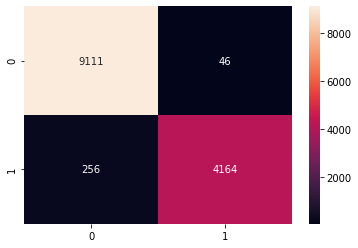

In [32]:
print_scores(tempDf['ActualValue'], tempDf['PredictedClass'])
print("ROC_AUC_Score: ", multiclass_roc_auc_score(tempDf['ActualValue'],tempDf['PredictedClass']))

In [33]:
print(len(L12))

8


In [0]:
# get the train test data for the actual assignment groups

X_train_Zero, Y_train_Zero, X_validation_Zero,Y_validation_Zero,X_train_One,X_validation_One,Y_train_One,Y_validation_One,partDfZero,partDfOne = PrepDataForModel_SecondLevelGrouping(df, maxlen)


In [0]:
# SECOND MODEL BEGINS HERE FOR GROUP 1 - All assignment groups that falls under L12 defined above

model_L12_AssignmentGroups = Sequential()
embedding=Embedding(len(embeddings),300,weights=[embeddings], input_length=maxlen,trainable=False)

model_L12_AssignmentGroups.add(embedding)
model_L12_AssignmentGroups.add(LSTM(maxlen))
model_L12_AssignmentGroups.add(Dense(100, activation='relu'))
model_L12_AssignmentGroups.add(Dropout(0.25) )
model_L12_AssignmentGroups.add(Dense(80, activation='relu'))
model_L12_AssignmentGroups.add(Dropout(0.25) )
model_L12_AssignmentGroups.add(Dense(40, activation='relu'))
model_L12_AssignmentGroups.add(Dropout(0.25) )
model_L12_AssignmentGroups.add(Dense(20, activation='relu'))
model_L12_AssignmentGroups.add(Dropout(0.25) )
model_L12_AssignmentGroups.add(Dense(10, activation='relu'))
model_L12_AssignmentGroups.add(Dropout(0.25) )

model_L12_AssignmentGroups.add(Dense(len(L12), activation='softmax'))
#model_L12_AssignmentGroups.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_L12_AssignmentGroups.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [36]:
history=model_L12_AssignmentGroups.fit(X_train_Zero,Y_train_Zero,batch_size=50,epochs=80, class_weight = 'auto',
                                                   validation_data=(X_validation_Zero,Y_validation_Zero),
                                                   callbacks=[early], 
                                                   verbose=1)

scores = model_L12_AssignmentGroups.evaluate(X_validation_Zero, Y_validation_Zero, verbose=1)
model_L12_AssignmentGroups.save("model_L12_AssignmentGroups.h5")

Train on 9140 samples, validate on 2285 samples
Epoch 1/80
9140/9140 [==============================] - 58s 6ms/step - loss: 2.0184 - acc: 0.2678 - val_loss: 1.9931 - val_acc: 0.2972
Epoch 2/80
9140/9140 [==============================] - 52s 6ms/step - loss: 1.9852 - acc: 0.2975 - val_loss: 1.9669 - val_acc: 0.2985
Epoch 3/80
9140/9140 [==============================] - 52s 6ms/step - loss: 1.9682 - acc: 0.3010 - val_loss: 1.9589 - val_acc: 0.2967
Epoch 4/80
9140/9140 [==============================] - 51s 6ms/step - loss: 1.9563 - acc: 0.3042 - val_loss: 1.9491 - val_acc: 0.2980
Epoch 5/80
9140/9140 [==============================] - 52s 6ms/step - loss: 1.9000 - acc: 0.3156 - val_loss: 1.7699 - val_acc: 0.3479
Epoch 6/80
9140/9140 [==============================] - 52s 6ms/step - loss: 1.7916 - acc: 0.3470 - val_loss: 1.7128 - val_acc: 0.3536
Epoch 7/80
9140/9140 [==============================] - 52s 6ms/step - loss: 1.7251 - acc: 0.3626 - val_loss: 1.6864 - val_acc: 0.3567
Epoch 8

In [0]:
y = model_L12_AssignmentGroups.predict(X_train_Zero)
predictedClass = np.argmax(y,axis=1).tolist()
actualClass = np.argmax(Y_train_Zero,axis=1).tolist()
    
tempDf_L12_AssignmentGroups = pd.DataFrame()
tempDf_L12_AssignmentGroups['ActualValue'] = pd.Series(actualClass)
tempDf_L12_AssignmentGroups['PredictedClass'] = pd.Series(predictedClass)

In [38]:
print(len(L3))

7


In [0]:
# SECOND MODEL BEGINS HERE FOR GROUP 2  - All assignment groups that falls under L3 defined above

model_L3_AssignmentGroups = Sequential()
embedding = Embedding(len(embeddings),300,weights=[embeddings], input_length=maxlen, trainable=False)

model_L3_AssignmentGroups.add(embedding)
model_L3_AssignmentGroups.add(LSTM(maxlen))
model_L3_AssignmentGroups.add(Dense(100, activation='relu'))
model_L3_AssignmentGroups.add(Dense(90, activation='relu'))
model_L3_AssignmentGroups.add(Dense(70, activation='relu'))
# model_L3_AssignmentGroups.add(Dropout(0.25) )

#L3 subgroups
model_L3_AssignmentGroups.add(Dense(len(L3), activation='softmax'))
#model_L3_AssignmentGroups.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_L3_AssignmentGroups.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [40]:
history=model_L3_AssignmentGroups.fit(X_train_One,Y_train_One, batch_size=10,epochs=50, class_weight = 'auto',
                                      validation_data=(X_validation_One,Y_validation_One),
                                      callbacks=[early], 
                                      verbose=1)

scores = model_L3_AssignmentGroups.evaluate(X_validation_One, Y_validation_One, verbose=1)

model_L3_AssignmentGroups.save("model_L3_AssignmentGroups.h5")

Train on 4437 samples, validate on 1109 samples
Epoch 1/50
4437/4437 [==============================] - 140s 32ms/step - loss: 1.9351 - acc: 0.1783 - val_loss: 1.9234 - val_acc: 0.1794
Epoch 2/50
4437/4437 [==============================] - 122s 28ms/step - loss: 1.9106 - acc: 0.1830 - val_loss: 1.8797 - val_acc: 0.2191
Epoch 3/50
4437/4437 [==============================] - 122s 28ms/step - loss: 1.8323 - acc: 0.2270 - val_loss: 1.7920 - val_acc: 0.2480
Epoch 4/50
4437/4437 [==============================] - 123s 28ms/step - loss: 1.6208 - acc: 0.3164 - val_loss: 1.4803 - val_acc: 0.3697
Epoch 5/50
4437/4437 [==============================] - 123s 28ms/step - loss: 1.3806 - acc: 0.4411 - val_loss: 1.3160 - val_acc: 0.4716
Epoch 6/50
4437/4437 [==============================] - 124s 28ms/step - loss: 1.2107 - acc: 0.5152 - val_loss: 1.1905 - val_acc: 0.5203
Epoch 7/50
4437/4437 [==============================] - 124s 28ms/step - loss: 0.9281 - acc: 0.6441 - val_loss: 0.9225 - val_acc: 

In [0]:
y = model_L3_AssignmentGroups.predict(X_train_One)
predictedClass = np.argmax(y,axis=1).tolist()
actualClass = np.argmax(Y_train_One,axis=1).tolist()
    
tempDf_L3_AssignmentGroups = pd.DataFrame()
tempDf_L3_AssignmentGroups['ActualValue'] = pd.Series(actualClass)
tempDf_L3_AssignmentGroups['PredictedClass'] = pd.Series(predictedClass)

In [0]:
PickleCustomObjects(embeddings,vocabulary,inverse_vocabulary)

### Section to print the Accuracy, Classification Report and Confusion Matrix

In [0]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = preprocessing.LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  return roc_auc_score(y_test, y_pred, average=average)

Showing Confusion Matrix for the Model trained over first level grouping of L12 and L3

Accuracy score: 
 0.977756499963173
Test-set confusion matrix:
 [[9111   46]
 [ 256 4164]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      9157
           1       0.99      0.94      0.97      4420

    accuracy                           0.98     13577
   macro avg       0.98      0.97      0.97     13577
weighted avg       0.98      0.98      0.98     13577

ROC_AUC_Score:  0.9685289843291758


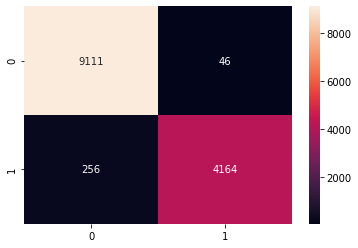

In [44]:
print_scores(tempDf['ActualValue'], tempDf['PredictedClass'])
print("ROC_AUC_Score: ", multiclass_roc_auc_score(tempDf['ActualValue'],tempDf['PredictedClass']))

Showing Confusion Matrix for the First Group L12 and within that Assignment Groups clubbed

Accuracy score: 
 0.9060175054704596
Test-set confusion matrix:
 [[2460   29   82   18    5   28    2    5]
 [   0 1128    0    0    0    0    0    0]
 [  57    4  758    4   20   81    0    6]
 [   0   92    0 1045   18    3    0    9]
 [   0    4    0    0  788    9    0   11]
 [   6    9   19    0   83  796    0    4]
 [   2   83    1    0    1    1  619   10]
 [   0  153    0    0    0    0    0  687]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.95      2629
           1       0.75      1.00      0.86      1128
           2       0.88      0.82      0.85       930
           3       0.98      0.90      0.94      1167
           4       0.86      0.97      0.91       812
           5       0.87      0.87      0.87       917
           6       1.00      0.86      0.93       717
           7       0.94      0.82      0.87       840

    accuracy                           0.91      9140
   macro avg       0.91 

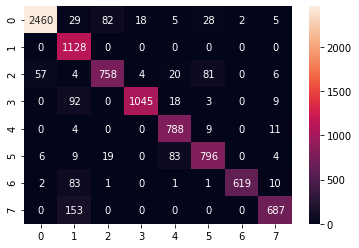

In [45]:
# tempDf_L12_AssignmentGroups
print_scores(tempDf_L12_AssignmentGroups['ActualValue'], tempDf_L12_AssignmentGroups['PredictedClass'])
print("ROC_AUC_Score: ", multiclass_roc_auc_score(tempDf_L12_AssignmentGroups['ActualValue'],tempDf_L12_AssignmentGroups['PredictedClass']))

Showing Confusion Matrix for the Second Group L3 and within that Assignment Groups clubbed

Accuracy score: 
 0.9725039441063782
Test-set confusion matrix:
 [[662   0   0   0   4   0   0]
 [  0 778   0   0   0   0   0]
 [  0   0 629   0   0   0   0]
 [  0   0   0 614   0   0   0]
 [  0   0   0   0 580   0   0]
 [  0   2   1   0   6 556  76]
 [  0   0   9   2   7  15 496]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       666
           1       1.00      1.00      1.00       778
           2       0.98      1.00      0.99       629
           3       1.00      1.00      1.00       614
           4       0.97      1.00      0.99       580
           5       0.97      0.87      0.92       641
           6       0.87      0.94      0.90       529

    accuracy                           0.97      4437
   macro avg       0.97      0.97      0.97      4437
weighted avg       0.97      0.97      0.97      4437

ROC_AUC_Score:  0.9833931895592495


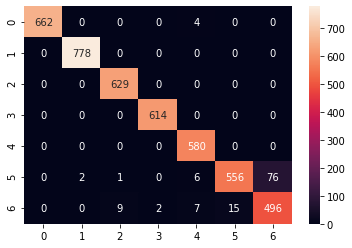

In [46]:
print_scores(tempDf_L3_AssignmentGroups['ActualValue'], tempDf_L3_AssignmentGroups['PredictedClass'])
print("ROC_AUC_Score: ", multiclass_roc_auc_score(tempDf_L3_AssignmentGroups['ActualValue'],tempDf_L3_AssignmentGroups['PredictedClass']))